In [2]:
import sys
import numpy as np
import pandas as pd
import pyabf
import mne
from data import mouse_names, mice_data
import matplotlib.pyplot as plt 

In [3]:
test_file = mice_data['week_0']['Ketamine']['after_5_min'][0]
test_file

'I mice/2022_07_26_27/2022_07_26_0005.abf'

In [4]:
mne.set_log_level('error') 
CHANNEL_NAMES = ['STI', 'Aux1', 'PFC']  # Name channels used in the experiment, note that order is important
CHANNEL_TYPES = ['stim', 'ecog', 'ecog']  # Name type of the channels used in the experiment

In [5]:
def import_ecog(filename: str):
    global CHANNEL_NAMES
    """
    It takes .abf file and converts it into EpochsArray, which is needed for further analyses with mne package
    :param filename: name of the .abf file, for example, '2022_05_12.abf'
    :return: returns EpochsArray object (for more information check `mne` package 
    documentation about EpochsArray object)
    """
    abf = pyabf.ABF(filename)  # reads .abf file
    n_channels = abf.channelCount  # find number of channels used in the .abf file
    sampling_rate = abf.dataRate  # Checks the sample rate used in the experiment of .abf file
    channel_names = CHANNEL_NAMES
    # First stimulus and then channels order in abf file.
    channel_types = CHANNEL_TYPES
    info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=channel_types)
    # Creates information part in the EpochsArray object
    events = [[x, 0, x + 1] for x in range(abf.sweepCount)]  # Calculate epochs/sweeps in the experiment
    tmin = 0
    data = np.empty([np.size(abf.sweepList), 3, np.size(abf.sweepX)])  # Creates empty array where sweeps data
    # will be added
    for isweep in abf.sweepList:  # for loop adds sweeps data into empty data array.
        # Channels order should be the same as in the .abf file
        # Aux1 channel
        abf.setSweep(isweep, channel=0)
        data[isweep, 0, :] = abf.sweepY
        # PFC channel
        abf.setSweep(isweep, channel=1)
        data[isweep, 1, :] = abf.sweepY
        # stim channel
        abf.setSweep(isweep, channel=2)
        data[isweep, 2, :] = abf.sweepY

    abf_epochs = mne.EpochsArray(data * 1e-6, info, events, tmin)  # Create EpochsArray object
    # We multiply data by 1e-6 to get V, because our data is recorded in uV but EpochsArray thinks that it is
    # recorded in V, so we get very low values later when it automatically tries to convert it into mV
    return abf_epochs

C:\Users\ernes\anaconda3\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


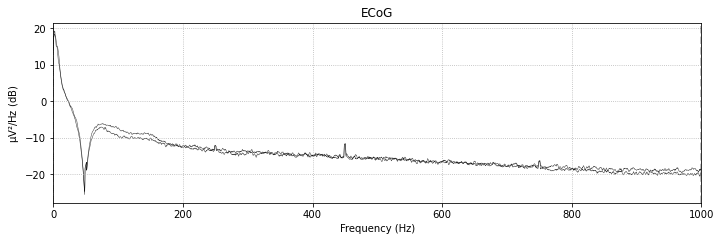

In [7]:
%matplotlib inline
import_ecog(test_file).plot_psd()
plt.show()

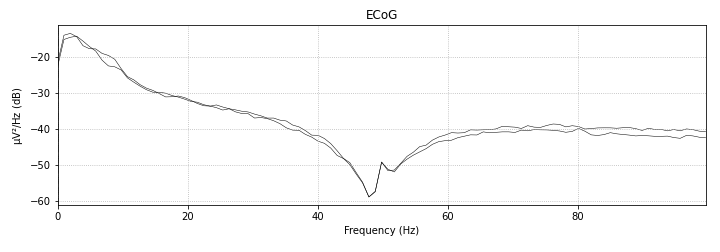

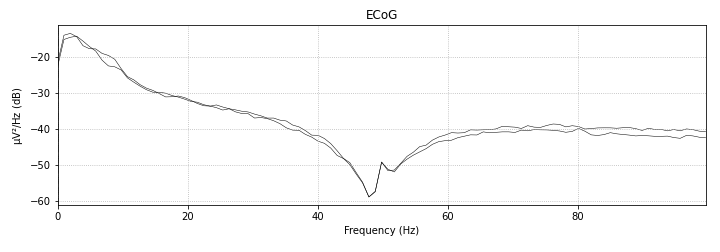

In [10]:
%matplotlib widget
import_ecog(test_file).plot_psd(fmin=0, fmax=100, spatial_colors=True, line_alpha=1, method='welch')
plt.show()

In [11]:
def psd(file_name: str, channels: list, filter_data=False, high_filt=0.5, low_filt=100,
        f_min=0.1, f_max=100, t_min=1.2, t_max=1.9, method='multitaper'):
    """
    This function takes one file with ecog recordings and calculate power spectral density (psd) for a given epoch time
    (t_min, t_max) and frequency interval (f_min, f_max) choosing from 'multitaper' or 'welch' method. It can filter
    psd by using filter_data=True parameter and exclude filtering range between high_filt and low_filt.
    :param file_name: Name of the .abf file, for example '2022_05_12.abf'
    :param filter_data: If True, filters data with highpass (high_filt) and lowpass (low_filt) filters. Default is False
    :param high_filt: A high-pass filter (HPF) is an electronic filter that passes signals with a frequency higher than
    a certain cutoff frequency and attenuates signals with frequencies lower than the cutoff frequency.
    :param low_filt: A low-pass filter (LPF) is a circuit that only passes signals below its cutoff frequency while
    attenuating all signals above it
    :param f_min: Value of the lowest frequency to show in the Power Spectrum Density plot. Default 0.1
    :param f_max: Value of the highest frequency to show in the Power Spectrum Density plot. Default 100
    :param t_min: Time point in the epoch where you want to start calculating power (in seconds). Default is 1.2.
    :param t_max: Time point in the epoch where you want to finish calculating power (in seconds). Default is 1.9.
    :param channels: Name of the channel to calculate the power (Default ['Aux1']).
    :param method: Method used to calcualte the power spectrum density plot. 2 possible variants - 'multitaper' and
    'welch'.
    :return: dataframe object with average power of given channel and file (ecog recording). Columns are named by
    given channels where index values are frequencies of interest.
    """
    file = import_ecog(file_name)  # imports .abf file as EpochsArray object

    if filter_data:
        file = file.copy().filter(high_filt, low_filt)  # If filter_data is True this function will take
        # electrophysiology data and filters it with the high and low bandpasses
    # More information about filtering https://mne.tools/stable/generated/mne.filter.filter_data.html

    else:
        pass  # If filter_data is False it will skip filtering function

    if method == 'welch':  # Perform spectral analysis on sensor data
        power_spectral_density = file.compute_psd(method='welch', fmin=f_min, fmax=f_max,
                                                  tmin=t_min, tmax=t_max, picks=channels, n_fft=1000)
        #  n_fft - The length of FFT used, must be >= n_per_seg (default: 256).
        #  The segments will be zero-padded if n_fft > n_per_seg
        #  psd returns the spectral representation of each epoch.
        #  https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html#mne.time_frequency.psd_array_welch

    elif method == 'multitaper':
        power_spectral_density = file.compute_psd(method='multitaper', fmin=f_min, fmax=f_max,
                                                  tmin=t_min, tmax=t_max, picks=channels, bandwidth=2)
        #  bandwidth - Half-bandwidth of the multi-taper window function in Hz.
        #  For a given frequency, frequencies at ± half-bandwidth are smoothed together.
        # https://mne.tools/stable/generated/mne.time_frequency.psd_array_multitaper.html#mne.time_frequency.psd_array_multitaper



    else:
        print("Wrong method!")  # If wrong method is select (for example, type error)
        # it will print 'Wrong method!' output
        sys.exit()

    # psd computes Power spectrum density (PSD) for every epoch, so if we have 100 epochs, after psd
    # it will output 100 PSDs.
    # 1 PSD consist of frequency column and power column, where each row represents frequency and power of particular
    # frequency.

    psd_df = power_spectral_density.to_data_frame()  # transforming psd output to data frame for further analysis
    psd_mean = psd_df.groupby(['freq']).mean(
        numeric_only=True)  # Group power values by frequency and calculate mean for each frequency
    psd_mean.drop('epoch', axis=1, inplace=True)  # Drop epoch column which is not necessary for further analysis

    # This `for` cycle converts Power of the channel from V (amplitude) to uV^2 - which is Power
    for x in channels:
        psd_mean[x] = (np.sqrt(psd_mean[x]) * 1e6) ** 2
    # Return data frame where 1st column is frequency index and other columns specifies power of brain area in uV^2
    # The column of power is named by brain area
    return psd_mean

In [12]:
psd_result = psd(test_file, channels=['Aux1', 'PFC'])
print(psd_result.to_string())

                Aux1        PFC
freq                           
1.427552   67.692401  42.611881
2.855103   52.708725  57.456426
4.282655   32.310819  41.846765
5.710207   30.997620  28.821463
7.137759   25.026200  14.214586
8.565310   18.762000  10.618008
9.992862    8.093526   7.225761
11.420414   4.384292   3.994189
12.847966   3.334792   3.121286
14.275517   2.837838   2.028406
15.703069   2.173069   2.318228
17.130621   1.724672   2.102241
18.558173   1.542723   1.486744
19.985724   1.429487   1.357045
21.413276   1.209997   1.098742
22.840828   0.802482   1.008061
24.268380   0.754875   0.907072
25.695931   0.710449   0.738392
27.123483   0.711656   0.638469
28.551035   0.605450   0.592237
29.978587   0.560510   0.426167
31.406138   0.513939   0.379794
32.833690   0.414308   0.356876
34.261242   0.341646   0.283958
35.688794   0.352034   0.184251
37.116345   0.260110   0.196334
38.543897   0.180599   0.166589
39.971449   0.153836   0.116180
41.399001   0.114782   0.089585
42.82655

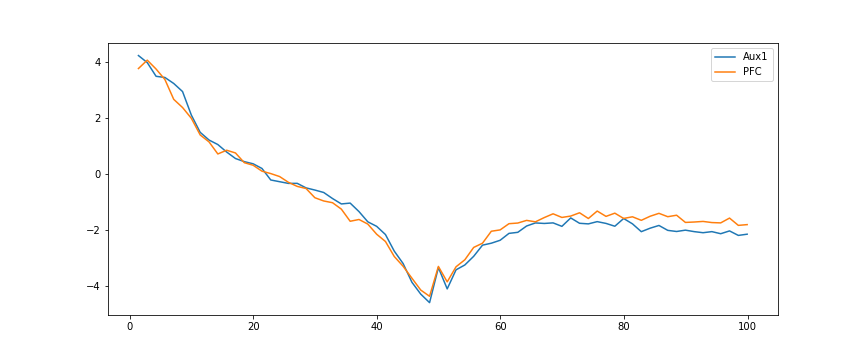

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(np.log(psd_result))
plt.legend(psd_result.columns)
plt.show()

In [14]:
def psd_calc(files_names: list, channels: list, calc='baseline', filt=False):
    """
    Depending on `calc` type, function calculates mean baseline, signal (response), ratio power of particular
    file_names (ecog recordings) group
    :param files_names: Give a list of particular subjects group (example - mouse), where each name in the list is
    .abf file. For example: ["2022_03_04_0000.abf", "2022_03_05_0000.abf"].
    :param channels: List of channels used for psd analysis, for example ['Aux1', 'PFC']
    :param calc: Choose from "baseline", "signal" (response), "ratio" calc parameters. "baseline" takes time window
    from 0.2 to 0.9 seconds and calculates power for that time window. "signal" takes time window from 1.2 to 1.9
    seconds.
    "ratio" takes "signal" and "baseline" power results and divides signal/baseline.
    :param filt: If filt parameter is True, then it uses filter which is described in 'psd' function
    :return: Returns data frame where medium baseline, response or ratio calculated from given .abf file list
    """
    if calc == 'baseline':

        df = psd(files_names[0], t_min=0.2, t_max=0.9, filter_data=filt,
                 channels=channels)  # Calls psd() function and takes first filename to create dataframe

        for x in range(1, len(files_names)):  # Iterates through every filename and put it in the psd()
            # function where it calculates baseline power
            # for a given mouse and add the result to the created dataframee
            df += psd(files_names[x], t_min=0.2, t_max=0.9, filter_data=filt, channels=channels)

    elif calc == 'signal':

        df = psd(files_names[0], t_min=1.2, t_max=1.9, filter_data=filt,
                 channels=channels)  # Calls psd() function and takes first filename to create dataframe
        for x in range(1, len(files_names)):  # Iterates through every filename and put it in the psd()
            # function where it calculates response power
            # for a given mouse and add the result to the created dataframee
            df += psd(files_names[x], t_min=1.2, t_max=1.9, filter_data=filt, channels=channels)

    elif calc == 'ratio':

        df_baseline = psd(files_names[0], t_min=0.2, t_max=0.9, filter_data=filt, channels=channels)
        df_signal = psd(files_names[0], t_min=1.2, t_max=1.9, filter_data=filt, channels=channels)
        df = df_signal / df_baseline  # Divides power of signal by baseline and use this df for iteration

        for x in range(1, len(files_names)):  # Iterates through every filename and put it in the psd()
            # function where it calculates ratio power
            # for a given mouse and add the result to the created dataframee
            df_baseline = psd(files_names[x], t_min=0.2, t_max=0.9, filter_data=filt, channels=channels)
            df_signal = psd(files_names[x], t_min=1.2, t_max=1.9, filter_data=filt, channels=channels)
            df_ratio = df_signal / df_baseline
            df += df_ratio

    else:  # If wrong 'calc' type were given it will print given string and returns 0
        print("Wrong calc parameter!")
        return 0

    df_final = df / len(files_names)  # Calculated mean power

    return df_final

In [15]:
test_file_2 = mice_data['week_0']['Ketamine']['after_5_min']
ket_5_min = psd_calc(test_file_2, ['Aux1', 'PFC'], calc='baseline')
print(ket_5_min.to_string())

                Aux1        PFC
freq                           
1.427552   40.193885  79.034937
2.855103   49.563701  94.103548
4.282655   47.247260  65.469339
5.710207   41.390380  41.385617
7.137759   34.741402  33.293822
8.565310   22.428514  23.048644
9.992862   10.104074  14.367830
11.420414   6.015701  10.503403
12.847966   4.483485   7.770205
14.275517   3.447474   5.982481
15.703069   2.801036   4.717433
17.130621   2.521956   4.119419
18.558173   2.148692   3.562339
19.985724   1.806666   2.914722
21.413276   1.556957   2.536924
22.840828   1.406281   2.257581
24.268380   1.211907   1.909162
25.695931   1.104642   1.643872
27.123483   0.970172   1.473882
28.551035   0.846221   1.265832
29.978587   0.729548   1.040037
31.406138   0.616361   0.890027
32.833690   0.511010   0.722882
34.261242   0.440254   0.584823
35.688794   0.354168   0.462994
37.116345   0.296195   0.375051
38.543897   0.215826   0.286172
39.971449   0.159520   0.217033
41.399001   0.116112   0.155758
42.82655

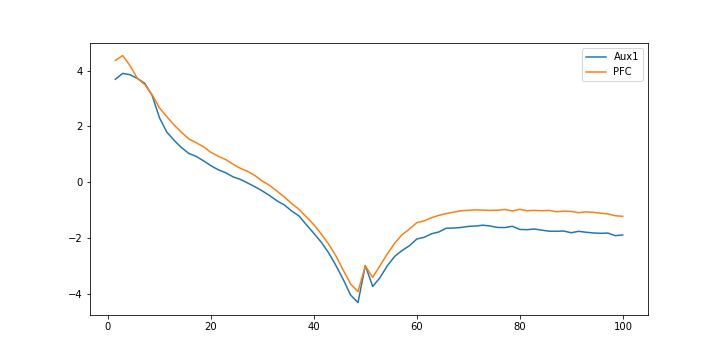

In [16]:
#%matplotlib inline
plt.figure(figsize = (10, 5))
plt.plot(np.log(ket_5_min))
plt.legend(ket_5_min.columns)
plt.show()

In [18]:
def psd_frequency_bands(filename: str, channels: list, mouse_name: str, experiment_phase='default_phase',
                        calc='baseline', frequency_40=False, all_freq=False):
    """
    This function calculates power for every ecog record (filename). Power of 40 Hz frequency band, baseline and
    response (signal) can be calculated.
    :param filename: abf file of ecog record (e.g. '2022_03_05_0000.abf')
    :param channels: Channels of interest that were used in ecog registration. e.g. ['Aux1', 'PFC']. If only one
    were given e.g. ['Aux1']
    :param mouse_name: Name of the mouse used in experiment e.g. 'A1'
    :param experiment_phase: Name of your experiment phase, for example, 'After KET'.
    :param calc: Epoch part we want to extract, for example, 'baseline' calculates psd in time range 0.2-0.9 s.
    'signal' (response) calculates psd power for time range 1.2-1.9 s.
    'ratio' divides signal psd by baseline psd
    :param frequency_40: If True, it extracts mean power of frequency range between (38-42) Hz
    default value is False
    :param all_freq: If True, it extracts every frequency we get from psd function.
    :return: DataFrame object. Columns - freq (index), channel_name (represent power), calc (calc method used), mouse
    (name of the mouse), experiment_phase.
    """
    # First part of function calculates psd
    # Depending on calc string value applied, if 'baseline', 'signal' (response) or 'ratio' were chosen then
    # it will calculate power spectral density subject to calc. If typo occur it will print 'Wrong 'calc' type'
    # and function returns None.
    if calc == 'baseline':
        psd_file = psd(filename, channels=channels, f_min=0, f_max=101, t_min=0.2, t_max=0.9)

    elif calc == 'signal':
        psd_file = psd(filename, channels=channels, f_min=0, f_max=101, t_min=1.2, t_max=1.9)

    elif calc == 'ratio':
        psd_file_baseline = psd(filename, channels=channels, f_min=0, f_max=101, t_min=0.2, t_max=0.9)
        psd_file_signal = psd(filename, channels=channels, f_min=0, f_max=101, t_min=1.2, t_max=1.9)
        psd_file = psd_file_signal / psd_file_baseline

    else:
        print("Wrong 'calc' type!")
        return None

    # This part of function determine which frequency range of psd we need. If we give frequency_40=True, this part then
    # takes mean of frequency range between 38 and 42 and put it into dataframe.
    if frequency_40:
        freq = psd_file[(psd_file.index > 38) & (psd_file.index < 42)].mean()
        freq['band_name'] = '40 hz'
        new_df = pd.DataFrame([freq])
    # If all_freq True then it takes all frequencies and put it into df without any splicing.
    elif all_freq:
        new_df = pd.DataFrame(psd_file)
    # If all_freq and frequency_40 are False then function splits frequencies into delta, theta, alpha, beta, low_gamma,
    # high_gamma frequencies and calculates mean power for every frequency band.
    else:
        delta = psd_file[(psd_file.index >= 0) & (psd_file.index <= 4)].mean()
        delta['band_name'] = 'delta'
        theta = psd_file[(psd_file.index >= 4) & (psd_file.index <= 8)].mean()
        theta['band_name'] = 'theta'
        alpha = psd_file[(psd_file.index >= 8) & (psd_file.index <= 12)].mean()
        alpha['band_name'] = 'alpha'
        beta = psd_file[(psd_file.index >= 12) & (psd_file.index <= 30)].mean()
        beta['band_name'] = 'beta'
        low_gamma = psd_file[(psd_file.index >= 30) & (psd_file.index <= 45)].mean()
        low_gamma['band_name'] = 'low gamma'
        high_gamma = psd_file[(psd_file.index >= 55) & (psd_file.index <= 90)].mean()
        high_gamma['band_name'] = 'high gamma'

        new_df = pd.DataFrame([delta, theta, alpha, beta, low_gamma, high_gamma])

    # To improve our DataFrame we append columns with calculation name, mouse name and experiment phase.
    new_df['calc'] = calc
    new_df['mouse'] = mouse_name
    new_df['experiment_phase'] = experiment_phase

    # Third part of function formats our dataframe from wide format to long format for easier application in
    # data analysis and construction of graphs. More info find in google: "wide and long data formats"
    if not all_freq:
        # This part applies when all_freq is False
        # For calc 'baseline' and 'signal' (response) we chose numerical parameter 'Power' as a value and brain area
        # as a variable name, other additional info are added to id_vars parameter.
        if calc == 'baseline' or calc == 'signal':
            melted_df = new_df.melt(id_vars=['mouse', 'experiment_phase', 'band_name', 'calc'],
                                    var_name='brain_area',
                                    value_name='Power')
            return melted_df
        # This part serves the same purpose as previous one but because value name are different
        # for ratio calculation I applied additional 'if' statement
        elif calc == 'ratio':
            melted_df = new_df.melt(id_vars=['mouse', 'experiment_phase', 'band_name', 'calc'],
                                    var_name='brain_area',
                                    value_name='Ratio')
            return melted_df

    else:
        return new_df

In [19]:
number_of_mice = range(len(test_file_2))
ket_5_min_40_hz = [psd_frequency_bands(test_file_2[x], calc='baseline', channels=['Aux1', 'PFC'],
                                         mouse_name=mouse_names[x], experiment_phase='After KET', frequency_40=True) 
                   for x in number_of_mice]
ket_5_min_40_hz

[  mouse experiment_phase band_name      calc brain_area     Power
 0    I2        After KET     40 hz  baseline       Aux1  0.133133
 1    I2        After KET     40 hz  baseline        PFC  0.106480,
   mouse experiment_phase band_name      calc brain_area     Power
 0    I3        After KET     40 hz  baseline       Aux1  0.166564
 1    I3        After KET     40 hz  baseline        PFC  0.227819,
   mouse experiment_phase band_name      calc brain_area     Power
 0    I4        After KET     40 hz  baseline       Aux1  0.183437
 1    I4        After KET     40 hz  baseline        PFC  0.294929,
   mouse experiment_phase band_name      calc brain_area     Power
 0    I5        After KET     40 hz  baseline       Aux1  0.118059
 1    I5        After KET     40 hz  baseline        PFC  0.174007,
   mouse experiment_phase band_name      calc brain_area     Power
 0    I6        After KET     40 hz  baseline       Aux1  0.131246
 1    I6        After KET     40 hz  baseline        PFC  

In [20]:
new_df = pd.DataFrame()
for df in ket_5_min_40_hz:
    new_df = pd.concat([new_df, df])
#new_df.drop("index", axis=1, inplace=True)
new_df

,mouse,experiment_phase,band_name,calc,brain_area,Power
0,I2,After KET,40 hz,baseline,Aux1,0.133133
1,I2,After KET,40 hz,baseline,PFC,0.106480
0,I3,After KET,40 hz,baseline,Aux1,0.166564
1,I3,After KET,40 hz,baseline,PFC,0.227819
0,I4,After KET,40 hz,baseline,Aux1,0.183437
1,I4,After KET,40 hz,baseline,PFC,0.294929
0,I5,After KET,40 hz,baseline,Aux1,0.118059
1,I5,After KET,40 hz,baseline,PFC,0.174007
0,I6,After KET,40 hz,baseline,Aux1,0.131246
1,I6,After KET,40 hz,baseline,PFC,0.208646


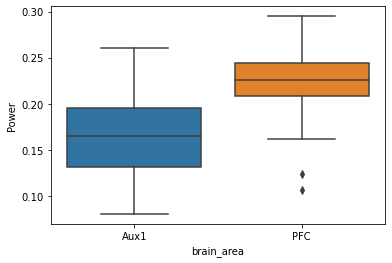

In [23]:
%matplotlib inline
import seaborn as sns
sns.boxplot(data=new_df, x='brain_area', y = 'Power')
plt.show()

In [24]:
number_of_mice = range(len(test_file_2))
ket_5_min_40_hz = [psd_frequency_bands(test_file_2[x], calc='baseline', channels=['Aux1', 'PFC'], all_freq=True,
                                         mouse_name=mouse_names[x], experiment_phase='After KET') 
                   for x in number_of_mice]

In [25]:
new_df = pd.DataFrame()
for df in ket_5_min_40_hz:
    new_df = pd.concat([new_df, df])
new_df.reset_index(inplace=True)
new_df

,freq,Aux1,PFC,calc,mouse,experiment_phase
0,0.000000,1.830409,1.485450,baseline,I2,After KET
1,1.427552,103.240396,80.907856,baseline,I2,After KET
2,2.855103,82.775097,86.066275,baseline,I2,After KET
3,4.282655,36.684308,49.214061,baseline,I2,After KET
4,5.710207,34.235350,31.923501,baseline,I2,After KET
...,...,...,...,...,...,...
1202,94.218415,0.136916,0.371682,baseline,M5,After KET
1203,95.645967,0.154431,0.380027,baseline,M5,After KET
1204,97.073519,0.162220,0.407366,baseline,M5,After KET
1205,98.501071,0.134956,0.333688,baseline,M5,After KET


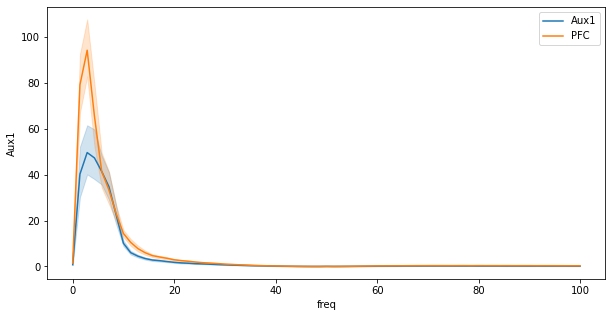

In [26]:
plt.figure(figsize=(10,5))
sns.lineplot(data=new_df, x="freq", y="Aux1")
sns.lineplot(data=new_df, x="freq", y="PFC")
plt.legend(['Aux1', 'PFC'])
plt.show()

In [27]:
def table_of_frequency_bands(data_list, channels, mice_names, experiment_phase, calc, freq_40):
    table = psd_frequency_bands(data_list[0], channels=channels, mouse_name=mice_names[0],
                                experiment_phase=experiment_phase, calc=calc, frequency_40=freq_40)
    for num in range(1, len(data_list)):
        psd_data = psd_frequency_bands(data_list[num], channels=channels, mouse_name=mice_names[num],
                                       experiment_phase=experiment_phase, calc=calc, frequency_40=freq_40)
        table = pd.concat([table, psd_data])

    return table

In [29]:
freq_table = table_of_frequency_bands(test_file_2, channels=['Aux1', 'PFC'],
                                                mice_names=mouse_names, experiment_phase="after_5_min_ket",
                                                calc='signal', freq_40=False)

In [30]:
freq_table

,mouse,experiment_phase,band_name,calc,brain_area,Power
0,I2,after_5_min_ket,delta,signal,Aux1,40.608282
1,I2,after_5_min_ket,theta,signal,Aux1,29.444880
2,I2,after_5_min_ket,alpha,signal,Aux1,10.413273
3,I2,after_5_min_ket,beta,signal,Aux1,1.415231
4,I2,after_5_min_ket,low gamma,signal,Aux1,0.243565
...,...,...,...,...,...,...
7,M5,after_5_min_ket,theta,signal,PFC,39.107828
8,M5,after_5_min_ket,alpha,signal,PFC,25.020123
9,M5,after_5_min_ket,beta,signal,PFC,3.837017
10,M5,after_5_min_ket,low gamma,signal,PFC,0.508685


C:\Users\ernes\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\ernes\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


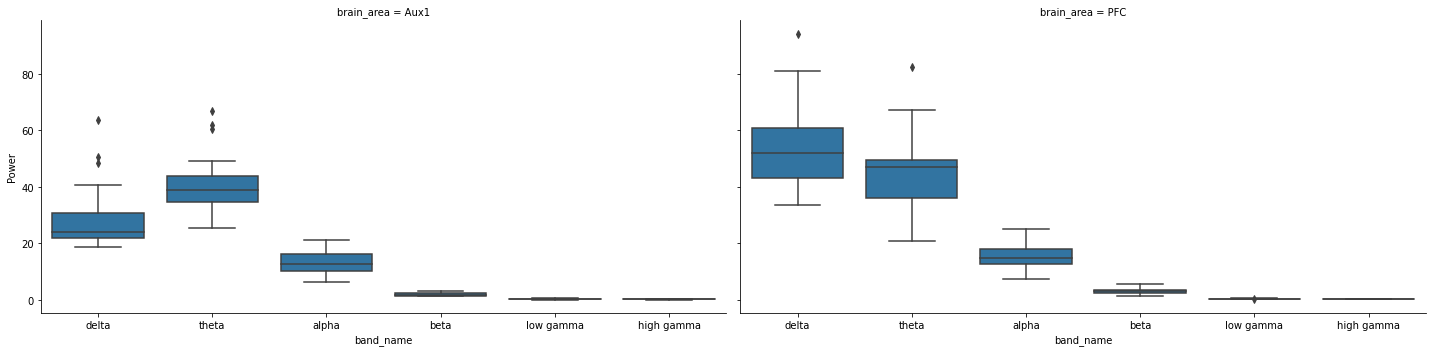

In [31]:
fig_shape= sns.FacetGrid(data=freq_table, col='brain_area', size=5, aspect=2)
fig_shape.map(sns.boxplot, 'band_name', 'Power')
plt.show()

In [32]:
def calc_itpc_power(file, channel):
    data = import_ecog(file).pick_channels(channel)
    freqs = np.linspace(20, 90, 71)
    n_cycles = np.logspace(*np.log10([7, 30]), 71)
    power, itc = mne.time_frequency.tfr_morlet(data, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                               return_itc=True, n_jobs=1)
    return power, itc

In [33]:
power, itc = calc_itpc_power(test_file, ['PFC', 'Aux1'])

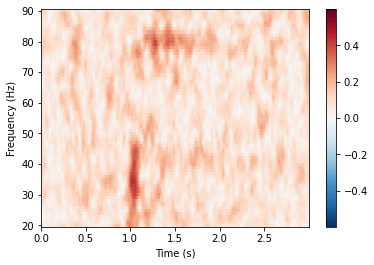

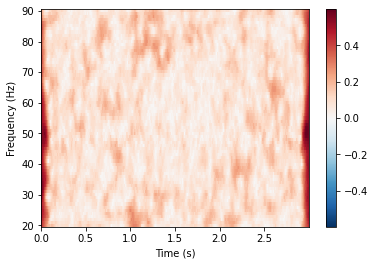

In [34]:
itc.plot()
plt.show()

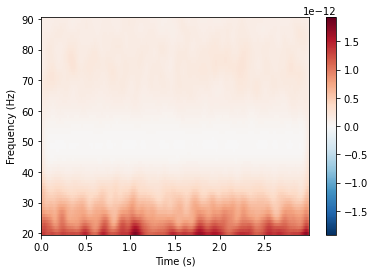

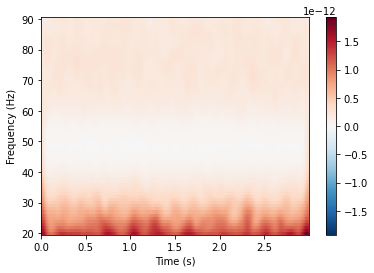

In [35]:
power.plot()
plt.show()